A dental disease recognition system based off of the YOLOv6 model

In [15]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


DEPRECATION: torchsde 0.2.5 has a non-standard dependency specifier numpy>=1.19.*; python_version >= "3.7". pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of torchsde or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: C:\Users\harry\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [8]:
# imports
from torchvision import datasets, transforms
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch import nn
from torch.optim import Adam
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import shutil
from sklearn.model_selection import train_test_split
from torch.utils.data import random_split
from sklearn.metrics import classification_report
from PIL import Image
from IPython.display import display
import os
import cv2
import random
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.models.transforms.outcome import Standardize
from botorch.optim import optimize_acqf
from botorch.acquisition.monte_carlo import qExpectedImprovement
import subprocess
import re
# from cnn import CNN
import matplotlib
matplotlib.use("Agg")



In [9]:
torch.cuda.set_per_process_memory_fraction(0.9)
torch.backends.cuda.matmul.allow_tf32 = False

# global variables

# image and label directorys
IMAGE_DIR = "data\\dental_dataset\\extended\\images"
LABEL_DIR = "data\\dental_dataset\\extended\\labels"

# define the train, val and test splits
TRAIN_SPLIT = 0.90
VAL_SPLIT = 0.10
TEST_SPLIT = 0

First is to rotate/flip the images then Split into train, validation and testing sets

In [2]:
def getBoundingBoxes(labelsDir, filename, img_width, img_height):
    '''
    function to get the bounding boxes of an image
    inputs:
    @param labelsDir: the directory for the image labels
    @param filename: the name of the image
    @param img_width: the width of the image associated with these labels
    @param img_height: the height of the image associated with these labels
    output: a list of bounding boxes in pixels (x1, y1, x2, y2)
    '''
    # get bounding box positions
    with open(labelsDir + "\\" + filename + ".txt", "r") as f:
        lines = f.readlines()
        bboxes = []
        for line in lines:
            class_id, norm_x_center, norm_y_center, norm_width, norm_height = map(float, line.split())

            class_id = int(class_id)
            x_center = int(norm_x_center * img_width)
            y_center = int(norm_y_center * img_height)
            width = int(norm_width * img_width)
            height = int(norm_height * img_height)

            x1 = int(x_center - width / 2)
            y1 = int(y_center - height / 2)
            x2 = int(x_center + width / 2)
            y2 = int(y_center + height / 2)
            bbox = (x1, y1, x2, y2)
            bboxes.append((bbox, class_id))
    return bboxes


def get_corners(bboxes):
    '''
    function to convert the bounding boxes from just 2 corners to all four corners
    inputs:
    @ param bboxes: the bounding boxes
    returns: corners, the new bounding boxes with 4 corners
    '''
    # get the width and height of the bounding boxes
    width = (bboxes[:,2] - bboxes[:,0]).reshape(-1,1)
    height = (bboxes[:,3] - bboxes[:,1]).reshape(-1,1)
    
    # calculate the 4 corners of each box
    x1 = bboxes[:,0].reshape(-1,1)
    y1 = bboxes[:,1].reshape(-1,1)
    
    x2 = x1 + width
    y2 = y1 
    
    x3 = x1
    y3 = y1 + height
    
    x4 = bboxes[:,2].reshape(-1,1)
    y4 = bboxes[:,3].reshape(-1,1)
    
    corners = np.hstack((x1,y1,x2,y2,x3,y3,x4,y4))
    
    return corners


def rotate(img, filename, degrees, labelsDir):
    '''
    function to rotate an image by some number of degrees
    inputs:
    @param img: the image to rotate
    @param filename: the name of the image
    @param degrees: the degrees to rotate the image by
    @param labelsDir: the directory for the image labels
    output: (rotated image, new bounding boxes)
    '''
    # get the width and height of the image
    image_width, image_height = img.shape[1], img.shape[0]
    bboxes = getBoundingBoxes(labelsDir, filename, image_width, image_height)
    ids = [box[1] for box in bboxes]
    bboxes = [box[0] for box in bboxes]
    
    bboxes = np.array(bboxes)
    new_bboxes = []
    # generate the rotation matrix
    image_center = (image_width / 2, image_height / 2)
    rotation_matrix = cv2.getRotationMatrix2D(image_center, degrees, 1)

    # compute the new bounding dimensions of the image to accommodate the new image
    cos = np.abs(rotation_matrix[0, 0])
    sin = np.abs(rotation_matrix[0, 1])
    new_image_width = int((image_height * sin) + (image_width * cos))
    new_image_height = int((image_height * cos) + (image_width * sin))

    # adjust the rotation matrix to take into account translation
    rotation_matrix[0, 2] += (new_image_width / 2) - image_center[0]
    rotation_matrix[1, 2] += (new_image_height / 2) - image_center[1]

    # apply the rotation to the image
    img = cv2.warpAffine(img, rotation_matrix, (new_image_width, new_image_height), borderValue=(255,255,255))
    if len(bboxes) == 0:
        return((img, bboxes))
    
    # get all 4 corners of the bounding boxes
    corners = get_corners(bboxes)
    corners = np.hstack((corners, bboxes[:,4:]))
    corners = corners.reshape(-1,2)
    corners = np.hstack((corners, np.ones((corners.shape[0],1), dtype = type(corners[0][0]))))
    # rotate the bounding boxes
    calculated = np.dot(rotation_matrix, corners[:,:8].T).T
    calculated = calculated.reshape(-1,8)
    corners = calculated

    # calculate new tight fitting bounding boxes to enclose each of the rotated ones
    x_ = corners[:,[0,2,4,6]]
    y_ = corners[:,[1,3,5,7]]
    
    xmin = np.min(np.around(x_),1).reshape(-1,1)
    ymin = np.min(np.around(y_),1).reshape(-1,1)
    xmax = np.max(np.around(x_),1).reshape(-1,1)
    ymax = np.max(np.around(y_),1).reshape(-1,1)
    
    corners = np.hstack((xmin, ymin, xmax, ymax, corners[:,8:])).astype(int)

    # Combine them into a list with nested tuple
    new_bboxes = [(tuple(arr_row), id) for arr_row, id in zip(corners, ids)]
    return((img, new_bboxes))

    
def flip(img, filename, axis, labelsDir):
    '''
    function to flip an image on one of its axis
    inputs:
    @param img: the image to flip
    @param filename: the name of the image
    @param axis: the axis to flip the image on
    @param labelsDir: the directory for the image labels
    output: (flipped image, new bounding boxes)
    '''
    # get the width and height of the image
    image_width, image_height = img.shape[1], img.shape[0]
    bboxes = getBoundingBoxes(labelsDir, filename, image_width, image_height)
    # flip the image
    img  = cv2.flip(img, axis)
    if len(bboxes) == 0:
        return((img, bboxes))

    image_center = (image_width / 2, image_height / 2)
    ids = [box[1] for box in bboxes]
    bboxes = [box[0] for box in bboxes]
    bboxes = np.array(bboxes).astype(float)

    # flip the bounding boxes
    if(axis == 1):
        # horizontal
        img_center = np.hstack((image_center, image_center))
        bboxes[:,[0,2]] += 2*(img_center[[0,2]] - bboxes[:,[0,2]])
            
        box_w = abs(bboxes[:,0] - bboxes[:,2])
             
        bboxes[:,0] -= box_w
        bboxes[:,2] += box_w
        bboxes = bboxes.astype(int)
    else:
        # vertical
        img_center = np.hstack((image_center, image_center))
        bboxes[:,[1,3]] += 2*(img_center[[1,3]] - bboxes[:,[1,3]])
            
        box_h = abs(bboxes[:,1] - bboxes[:,3])
             
        bboxes[:,1] -= box_h
        bboxes[:,3] += box_h
        bboxes = bboxes.astype(int)

    new_bboxes = [(tuple(arr_row), id) for arr_row, id in zip(bboxes, ids)]

    return((img, new_bboxes))


def formatBoundingBoxes(bboxes, img):
    '''
    function to format bounding boxes ready for saving in a file
    inputs:
    @param bboxes: the bounding boxes in a [(x1, y1, x2, y2), class_id] format as pixel values
    @param img: the image associated with these bounding boxes
    outputs: the bounding boxes in the correct format [(cx, cy, w, h), class_id] normalized
    '''
    ids = [box[1] for box in bboxes]
    bboxes = [box[0] for box in bboxes]
    bboxes = np.array(bboxes).astype(float)
    w = bboxes[:,2] - bboxes[:,0]
    h = bboxes[:,3] - bboxes[:,1]
    cx = bboxes[:,0] + (w[:] / 2)
    cy = bboxes[:,1] + (h[:] / 2)

    # normalize the data
    image_width, image_height = img.shape[1], img.shape[0]
    w = w / image_width
    cx = cx / image_width
    h = h / image_height
    cy = cy / image_height

    bboxes = np.column_stack((cx, cy, w, h))
    new_bboxes = [(tuple(arr_row), id) for arr_row, id in zip(bboxes, ids)]
    return new_bboxes


def writeLabels(labelsDir, filename, bboxes):
    '''
    function save bounding boxes as labels in a txt file
    inputs:
    @param labelsDir: the directory of the labels
    @param filename: the name of the image that these labels are for
    @param bboxes: the bounding boxes to write
    '''
    with open(labelsDir + "\\" + filename + ".txt", "w") as f:
        if len(bboxes) != 0:
            for bbox, id in bboxes:
                str_bbox = " ".join(map(str, bbox))
                line = str(id) + " " + str_bbox
                f.write(line)
        else:
            f.write("")
        f.close()

# Create an empty list to store the images
images = []
filenames = []
# Iterate through all files in the directory
for filename in os.listdir(IMAGE_DIR):
    # Check if the file is an image
    if filename.endswith(".jpg") or filename.endswith(".png"):
            # Construct the full file path
            filepath = os.path.join(IMAGE_DIR, filename)
            # Read the image and its label file
            try:
                img = cv2.imread(filepath)
                # Add the image to the list
                images.append(img)
                filenames.append(filename[:-4])
            except Exception as e:
                print(f"Error reading image {filename}: {e}")



# Rotate or flip images
for index, img in enumerate(images):
    # Generate a random boolean value (True/False) with equal probability
    random_bool = np.random.choice([True, False])
    # Convert the boolean to 0 or 1
    r1 = int(random_bool)
    if(r1 == 0):
        # rotate
        degrees = random.uniform(-5, 5)
        img, bboxes = rotate(img, filenames[index], degrees, LABEL_DIR)
        # set the file name
        filename = filenames[index] + "-rotated"
    else:
        # flip
        random_bool = np.random.choice([True, False])
        r2 = int(random_bool)
        img, bboxes = flip(img, filenames[index], r2, LABEL_DIR)
        # set the file name
        filename = filenames[index] + "-flipped"
    
    # format the bounding boxes
    if len(bboxes) != 0:
            bboxes = formatBoundingBoxes(bboxes, img)

    # save the image and its labels
    cv2.imwrite(os.path.join(IMAGE_DIR, filename + ".jpg"), img)
    writeLabels(LABEL_DIR, filename, bboxes)

In [69]:
# split image paths and preserve label associations
if(not (os.path.exists(IMAGE_DIR+"/train") & os.path.exists(IMAGE_DIR+"/test") & os.path.exists(IMAGE_DIR+"/val") & os.path.exists(LABEL_DIR+"/train") & os.path.exists(LABEL_DIR+"/test") & os.path.exists(LABEL_DIR+"/val"))):
    image_paths = [os.path.join(IMAGE_DIR, f) for f in os.listdir(IMAGE_DIR)]
    label_paths = [os.path.join(LABEL_DIR, f) for f in os.listdir(LABEL_DIR)]

    image_paths_train, image_paths_val = train_test_split(image_paths, train_size=TRAIN_SPLIT)
    # image_paths_val, image_paths_test = train_test_split(image_paths_temp, test_size=VAL_SPLIT/(VAL_SPLIT+TEST_SPLIT))
    image_paths_test = []

    label_paths_train = [f for f in label_paths if os.path.basename(f)[:-4] in [os.path.basename(p)[:-4] for p in image_paths_train]]
    label_paths_val = [f for f in label_paths if os.path.basename(f)[:-4] in [os.path.basename(p)[:-4] for p in image_paths_val]]
    label_paths_test = [f for f in label_paths if os.path.basename(f)[:-4] in [os.path.basename(p)[:-4] for p in image_paths_test]]

    # make the directories for the train, val and test images
    os.makedirs(IMAGE_DIR + "\\train", exist_ok=True)
    os.makedirs(IMAGE_DIR + "\\val", exist_ok=True)
    os.makedirs(IMAGE_DIR + "\\test", exist_ok=True)

    # make the directories for the train, val and test labels
    os.makedirs(LABEL_DIR + "\\train", exist_ok=True)
    os.makedirs(LABEL_DIR + "\\val", exist_ok=True)
    os.makedirs(LABEL_DIR + "\\test", exist_ok=True)

    # split images into tain, val and test sets
    print("moving training data")
    for image_path, label_path in zip(image_paths_train, label_paths_train):
        shutil.move(image_path, IMAGE_DIR + "\\train")
        shutil.move(label_path, LABEL_DIR + "\\train")

    print("moving val data")
    for image_path, label_path in zip(image_paths_val, label_paths_val):
        shutil.move(image_path, IMAGE_DIR + "\\val")
        shutil.move(label_path, LABEL_DIR + "\\val")

    print("moving test data")
    for image_path, label_path in zip(image_paths_test, label_paths_test):
        shutil.move(image_path, IMAGE_DIR + "\\test")
        shutil.move(label_path, LABEL_DIR + "\\test")

moving training data
moving val data
moving test data


In [7]:
# make sure the GPU is available
torch.cuda.is_available()
torch.cuda.get_device_name(0)

'NVIDIA GeForce GTX 1060 6GB'

# TRAINING


In [29]:
!python tools/train.py --batch 16 --conf configs/yolov6s_final_config.py --data data/dataset.yaml --device 0 --epochs 30 --workers 9 --eval-final-only --name self_attention

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.07s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.35s).
Accumulating evaluation results...
DONE (t=0.27s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.647
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.865
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.735
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.450
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.649
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.361
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.729
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDet

Using 1 GPU for training... 
training args are: Namespace(data_path='data/dataset.yaml', conf_file='configs/yolov6s_final_config.py', img_size=640, rect=False, batch_size=16, epochs=30, workers=9, device='0', eval_interval=20, eval_final_only=True, heavy_eval_range=50, check_images=False, check_labels=False, output_dir='./runs/train', name='self_attention', dist_url='env://', gpu_count=0, local_rank=-1, resume=False, write_trainbatch_tb=False, stop_aug_last_n_epoch=15, save_ckpt_on_last_n_epoch=-1, distill=False, distill_feat=False, quant=False, calib=False, teacher_model_path=None, temperature=20, fuse_ab=False, bs_per_gpu=32, specific_shape=False, height=None, width=None, cache_ram=False, rank=-1, world_size=1, save_dir='runs\\train\\self_attention1')

Loading state_dict from runs\train\enhanced\weights\best_ckpt.pt for fine-tuning...
Model: Model(
  (backbone): EfficientRep(
    (stem): RepVGGBlock(
      (nonlinearity): ReLU(inplace=True)
      (se): Identity()
      (rbr_dense): C

In [2]:
!python tools/train.py --batch 16 --conf configs/yolov6s6.py --data data/dataset.yaml --device 0 --epochs 5 --workers 9 --eval-final-only --name light_train

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.42s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.10s).
Accumulating evaluation results...
DONE (t=0.11s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.002
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.006
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDet

Using 1 GPU for training... 
training args are: Namespace(data_path='data/dataset.yaml', conf_file='configs/yolov6s6.py', img_size=640, rect=False, batch_size=16, epochs=5, workers=9, device='0', eval_interval=20, eval_final_only=True, heavy_eval_range=50, check_images=False, check_labels=False, output_dir='./runs/train', name='light_train', dist_url='env://', gpu_count=0, local_rank=-1, resume=False, write_trainbatch_tb=False, stop_aug_last_n_epoch=15, save_ckpt_on_last_n_epoch=-1, distill=False, distill_feat=False, quant=False, calib=False, teacher_model_path=None, temperature=20, fuse_ab=False, bs_per_gpu=32, specific_shape=False, height=None, width=None, cache_ram=False, rank=-1, world_size=1, save_dir='runs\\train\\light_train')

Model: Model(
  (backbone): EfficientRep6(
    (stem): RepVGGBlock(
      (nonlinearity): ReLU(inplace=True)
      (se): Identity()
      (rbr_dense): ConvModule(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)

In [6]:
# hyper parameter tuning
from yolov6.utils.config import Config


def modify_dict_string(string, key, new_value):
    """Modifies a string containing Python dictionary code by changing a specific key's value."""

    lines = string.splitlines()
    for i, line in enumerate(lines):
        if key in line:
            parts = line.split("=")
            parts[1] = str(new_value) + ","  # Ensure new value is a string
            lines[i] = "=".join(parts)
            break

    modified_string = "\n".join(lines)
    return modified_string


def get_map(string):
    # Regex pattern to match "mAP@0.5:" followed by a space and the value
    pattern = r"mAP@0\.5:\s+(\d|.+)\s+\|"

    match = re.search(pattern, string)
    if match:
        map_05_value = match.group(1)  # Extract the matched value
        return float(map_05_value)
    else:
        print("mAP@0.5 value not found in the string.")
        return 0.0


def read_cfg_file():
    """read the config file"""
    cfg = Config.fromfile("configs\\yolov6s6_optimal.py")
    text = cfg.text
    # "text" has the file name appended to the begining of it so this just removes that
    comment_index = text.find("#")
    text = text[comment_index:]
    filename = cfg.filename
    return text, filename


def modify_cfg(text, x):
    """change the hyperparameters in the config text"""
    text = modify_dict_string(text, "lr0", x[0].item())
    text = modify_dict_string(text, "lrf", x[1].item())
    text = modify_dict_string(text, "momentum", x[2].item())
    text = modify_dict_string(text, "weight_decay", x[3].item())
    return text



def save_cfg(text, filename):
    """save the text config to the config file"""
    with open(filename, 'w') as f:
            f.write(text)


def objective(train_x):
    """the objective function, in this case the model"""
    # read the config file
    text, filename = read_cfg_file()
    
    train_y = []
    for x in train_x:
        text = modify_cfg(text, x)
        # write the new config
        save_cfg(text, filename)
        # train the model and capture output
        command = "python tools/train.py --batch 16 --conf configs/yolov6s6_optimal.py --data data/dataset.yaml --device 0 --epochs 5 --workers 9 --eval-final-only --name semi_enhanced_large_hyperperam_optim"
        process = subprocess.run(command, shell=True, check=True, capture_output=True, text=True, encoding="UTF-8")
        output = process.stderr
        mapVal = get_map(output)
        train_y.append(mapVal)
    return torch.tensor(train_y)




def generate_inital_samples(n, params, bounds):
    """generate initial points"""
    train_x = torch.empty(n, params, dtype=torch.float32)
    for i in range(params):
        # Extract min and max bounds for the current column
        min_bound = bounds[0, i]
        max_bound = bounds[1, i]
        # Generate random values within the bounds for this column
        random_column = torch.rand(n, dtype=torch.float64) * (max_bound - min_bound) + min_bound
        # Assign the generated column to the corresponding position in the final tensor
        train_x[:, i] = random_column
    train_y = objective(train_x).unsqueeze(-1)
    best_val = train_y.max().item()
    return train_x, train_y, best_val




def get_suggested_points(train_x, train_y, best_val, bounds, numOfPoints):
    """function to get the suggested points to try"""
    # apply surrogate model
    surrogate = SingleTaskGP(train_x, train_y)
    mll = ExactMarginalLogLikelihood(surrogate.likelihood, surrogate)
    fit_gpytorch_mll(mll)

    # acquisition function
    expectedImprovement = qExpectedImprovement(
        model = surrogate,
        best_f = best_val
    )

    # optimize
    candidates, _ = optimize_acqf(
        acq_function = expectedImprovement,
        bounds=bounds,
        q=numOfPoints,
        num_restarts=200,
        raw_samples=512,
    )
    return candidates





loop = 10
numOfCandidates = 5
numOfParams = 4
numOfInitialPoints = 20
bounds = torch.tensor([[0.005, 0.001, 0.65, 0.0001], [0.1, 0.1, 0.9, 0.01]])
initial_x, initial_y, best_initial_val = generate_inital_samples(numOfInitialPoints, numOfParams, bounds)
print(f"initial mAP: {initial_y}")
train_x = initial_x
train_y = initial_y
best_val = best_initial_val
for i in range(loop):
    print(f"iteration {i}")
    print(f"candidates: {train_x}")
    new_x = get_suggested_points(train_x, train_y, best_val, bounds, numOfCandidates)
    new_y = objective(new_x).unsqueeze(-1)

    # add the new points
    train_x = torch.cat([train_x, new_x])
    train_y = torch.cat([train_y, new_y])
    print(f"mAP: {train_y}")
    best_val = train_y.max().item()

print(f"best mAP: {best_val}")
best_index = torch.argmax(train_y)
best_params = train_x[best_index]
print(f"the best hyperparameters: {best_params}")

# write the best parameters to the file
text, filename = read_cfg_file()
text = modify_cfg(text, best_params)
save_cfg(text, filename)



initial mAP: tensor([[2.6250e-01],
        [2.8598e-02],
        [1.3314e-02],
        [2.1268e-01],
        [5.2397e-02],
        [2.6152e-01],
        [1.1299e-01],
        [1.2247e-01],
        [2.3730e-01],
        [8.1638e-02],
        [2.0771e-01],
        [1.9900e-01],
        [4.4855e-06],
        [1.7571e-01],
        [2.1063e-01],
        [1.8365e-01],
        [2.6205e-01],
        [2.8280e-04],
        [1.2431e-03],
        [1.4297e-01]])
iteration 0
candidates: tensor([[1.0424e-02, 3.9164e-02, 8.1190e-01, 1.6335e-03],
        [9.0518e-02, 4.0583e-03, 6.5514e-01, 2.9581e-03],
        [8.3586e-02, 6.4690e-02, 6.5640e-01, 4.5199e-03],
        [4.0421e-02, 9.4508e-02, 7.4265e-01, 6.5331e-04],
        [7.2874e-02, 4.0085e-02, 6.6417e-01, 5.6578e-03],
        [7.2774e-02, 1.5032e-02, 8.4150e-01, 5.8256e-04],
        [3.0632e-02, 1.0557e-02, 7.4929e-01, 7.7689e-03],
        [4.0596e-02, 7.3029e-02, 6.5002e-01, 4.0325e-03],
        [8.2489e-02, 6.5480e-02, 8.1246e-01, 1.5823e-04],


C:\Users\harry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\botorch\models\gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=transformed_X, Y=train_Y, Yvar=train_Yvar)
C:\Users\harry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\botorch\models\utils\assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.1384]), std = tensor([0.0959])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


mAP: tensor([[2.6250e-01],
        [2.8598e-02],
        [1.3314e-02],
        [2.1268e-01],
        [5.2397e-02],
        [2.6152e-01],
        [1.1299e-01],
        [1.2247e-01],
        [2.3730e-01],
        [8.1638e-02],
        [2.0771e-01],
        [1.9900e-01],
        [4.4855e-06],
        [1.7571e-01],
        [2.1063e-01],
        [1.8365e-01],
        [2.6205e-01],
        [2.8280e-04],
        [1.2431e-03],
        [1.4297e-01],
        [2.7783e-01],
        [2.5324e-01],
        [2.7862e-01],
        [2.7921e-01],
        [2.7176e-01]])
iteration 1
candidates: tensor([[1.0424e-02, 3.9164e-02, 8.1190e-01, 1.6335e-03],
        [9.0518e-02, 4.0583e-03, 6.5514e-01, 2.9581e-03],
        [8.3586e-02, 6.4690e-02, 6.5640e-01, 4.5199e-03],
        [4.0421e-02, 9.4508e-02, 7.4265e-01, 6.5331e-04],
        [7.2874e-02, 4.0085e-02, 6.6417e-01, 5.6578e-03],
        [7.2774e-02, 1.5032e-02, 8.4150e-01, 5.8256e-04],
        [3.0632e-02, 1.0557e-02, 7.4929e-01, 7.7689e-03],
        [4.059

C:\Users\harry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\botorch\models\gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=transformed_X, Y=train_Y, Yvar=train_Yvar)
C:\Users\harry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\botorch\models\utils\assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.1652]), std = tensor([0.1014])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


mAP: tensor([[2.6250e-01],
        [2.8598e-02],
        [1.3314e-02],
        [2.1268e-01],
        [5.2397e-02],
        [2.6152e-01],
        [1.1299e-01],
        [1.2247e-01],
        [2.3730e-01],
        [8.1638e-02],
        [2.0771e-01],
        [1.9900e-01],
        [4.4855e-06],
        [1.7571e-01],
        [2.1063e-01],
        [1.8365e-01],
        [2.6205e-01],
        [2.8280e-04],
        [1.2431e-03],
        [1.4297e-01],
        [2.7783e-01],
        [2.5324e-01],
        [2.7862e-01],
        [2.7921e-01],
        [2.7176e-01],
        [5.7922e-02],
        [2.3628e-01],
        [2.3907e-01],
        [2.5606e-01],
        [1.9531e-01]])
iteration 2
candidates: tensor([[1.0424e-02, 3.9164e-02, 8.1190e-01, 1.6335e-03],
        [9.0518e-02, 4.0583e-03, 6.5514e-01, 2.9581e-03],
        [8.3586e-02, 6.4690e-02, 6.5640e-01, 4.5199e-03],
        [4.0421e-02, 9.4508e-02, 7.4265e-01, 6.5331e-04],
        [7.2874e-02, 4.0085e-02, 6.6417e-01, 5.6578e-03],
        [7.2774e-02,

C:\Users\harry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\botorch\models\gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=transformed_X, Y=train_Y, Yvar=train_Yvar)
C:\Users\harry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\botorch\models\utils\assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.1705]), std = tensor([0.0977])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


mAP: tensor([[2.6250e-01],
        [2.8598e-02],
        [1.3314e-02],
        [2.1268e-01],
        [5.2397e-02],
        [2.6152e-01],
        [1.1299e-01],
        [1.2247e-01],
        [2.3730e-01],
        [8.1638e-02],
        [2.0771e-01],
        [1.9900e-01],
        [4.4855e-06],
        [1.7571e-01],
        [2.1063e-01],
        [1.8365e-01],
        [2.6205e-01],
        [2.8280e-04],
        [1.2431e-03],
        [1.4297e-01],
        [2.7783e-01],
        [2.5324e-01],
        [2.7862e-01],
        [2.7921e-01],
        [2.7176e-01],
        [5.7922e-02],
        [2.3628e-01],
        [2.3907e-01],
        [2.5606e-01],
        [1.9531e-01],
        [2.2328e-01],
        [2.7862e-01],
        [2.7921e-01],
        [2.5739e-01],
        [2.4681e-01]])
iteration 3
candidates: tensor([[1.0424e-02, 3.9164e-02, 8.1190e-01, 1.6335e-03],
        [9.0518e-02, 4.0583e-03, 6.5514e-01, 2.9581e-03],
        [8.3586e-02, 6.4690e-02, 6.5640e-01, 4.5199e-03],
        [4.0421e-02, 9.450

C:\Users\harry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\botorch\models\gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=transformed_X, Y=train_Y, Yvar=train_Yvar)
C:\Users\harry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\botorch\models\utils\assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.1828]), std = tensor([0.0957])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


mAP: tensor([[2.6250e-01],
        [2.8598e-02],
        [1.3314e-02],
        [2.1268e-01],
        [5.2397e-02],
        [2.6152e-01],
        [1.1299e-01],
        [1.2247e-01],
        [2.3730e-01],
        [8.1638e-02],
        [2.0771e-01],
        [1.9900e-01],
        [4.4855e-06],
        [1.7571e-01],
        [2.1063e-01],
        [1.8365e-01],
        [2.6205e-01],
        [2.8280e-04],
        [1.2431e-03],
        [1.4297e-01],
        [2.7783e-01],
        [2.5324e-01],
        [2.7862e-01],
        [2.7921e-01],
        [2.7176e-01],
        [5.7922e-02],
        [2.3628e-01],
        [2.3907e-01],
        [2.5606e-01],
        [1.9531e-01],
        [2.2328e-01],
        [2.7862e-01],
        [2.7921e-01],
        [2.5739e-01],
        [2.4681e-01],
        [2.6395e-01],
        [2.8232e-01],
        [2.7921e-01],
        [2.7862e-01],
        [2.5656e-01]])
iteration 4
candidates: tensor([[1.0424e-02, 3.9164e-02, 8.1190e-01, 1.6335e-03],
        [9.0518e-02, 4.0583e-03,

C:\Users\harry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\botorch\models\gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=transformed_X, Y=train_Y, Yvar=train_Yvar)
C:\Users\harry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\botorch\models\utils\assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.1940]), std = tensor([0.0943])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


mAP: tensor([[2.6250e-01],
        [2.8598e-02],
        [1.3314e-02],
        [2.1268e-01],
        [5.2397e-02],
        [2.6152e-01],
        [1.1299e-01],
        [1.2247e-01],
        [2.3730e-01],
        [8.1638e-02],
        [2.0771e-01],
        [1.9900e-01],
        [4.4855e-06],
        [1.7571e-01],
        [2.1063e-01],
        [1.8365e-01],
        [2.6205e-01],
        [2.8280e-04],
        [1.2431e-03],
        [1.4297e-01],
        [2.7783e-01],
        [2.5324e-01],
        [2.7862e-01],
        [2.7921e-01],
        [2.7176e-01],
        [5.7922e-02],
        [2.3628e-01],
        [2.3907e-01],
        [2.5606e-01],
        [1.9531e-01],
        [2.2328e-01],
        [2.7862e-01],
        [2.7921e-01],
        [2.5739e-01],
        [2.4681e-01],
        [2.6395e-01],
        [2.8232e-01],
        [2.7921e-01],
        [2.7862e-01],
        [2.5656e-01],
        [2.5694e-01],
        [2.6869e-01],
        [2.8018e-01],
        [2.5510e-01],
        [2.4972e-01]])
iter

C:\Users\harry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\botorch\models\gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=transformed_X, Y=train_Y, Yvar=train_Yvar)
C:\Users\harry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\botorch\models\utils\assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.2016]), std = tensor([0.0914])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


mAP: tensor([[2.6250e-01],
        [2.8598e-02],
        [1.3314e-02],
        [2.1268e-01],
        [5.2397e-02],
        [2.6152e-01],
        [1.1299e-01],
        [1.2247e-01],
        [2.3730e-01],
        [8.1638e-02],
        [2.0771e-01],
        [1.9900e-01],
        [4.4855e-06],
        [1.7571e-01],
        [2.1063e-01],
        [1.8365e-01],
        [2.6205e-01],
        [2.8280e-04],
        [1.2431e-03],
        [1.4297e-01],
        [2.7783e-01],
        [2.5324e-01],
        [2.7862e-01],
        [2.7921e-01],
        [2.7176e-01],
        [5.7922e-02],
        [2.3628e-01],
        [2.3907e-01],
        [2.5606e-01],
        [1.9531e-01],
        [2.2328e-01],
        [2.7862e-01],
        [2.7921e-01],
        [2.5739e-01],
        [2.4681e-01],
        [2.6395e-01],
        [2.8232e-01],
        [2.7921e-01],
        [2.7862e-01],
        [2.5656e-01],
        [2.5694e-01],
        [2.6869e-01],
        [2.8018e-01],
        [2.5510e-01],
        [2.4972e-01],
     

C:\Users\harry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\botorch\models\gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=transformed_X, Y=train_Y, Yvar=train_Yvar)
C:\Users\harry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\botorch\models\utils\assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.1975]), std = tensor([0.0941])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
C:\Users\harry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-pac

mAP: tensor([[2.6250e-01],
        [2.8598e-02],
        [1.3314e-02],
        [2.1268e-01],
        [5.2397e-02],
        [2.6152e-01],
        [1.1299e-01],
        [1.2247e-01],
        [2.3730e-01],
        [8.1638e-02],
        [2.0771e-01],
        [1.9900e-01],
        [4.4855e-06],
        [1.7571e-01],
        [2.1063e-01],
        [1.8365e-01],
        [2.6205e-01],
        [2.8280e-04],
        [1.2431e-03],
        [1.4297e-01],
        [2.7783e-01],
        [2.5324e-01],
        [2.7862e-01],
        [2.7921e-01],
        [2.7176e-01],
        [5.7922e-02],
        [2.3628e-01],
        [2.3907e-01],
        [2.5606e-01],
        [1.9531e-01],
        [2.2328e-01],
        [2.7862e-01],
        [2.7921e-01],
        [2.5739e-01],
        [2.4681e-01],
        [2.6395e-01],
        [2.8232e-01],
        [2.7921e-01],
        [2.7862e-01],
        [2.5656e-01],
        [2.5694e-01],
        [2.6869e-01],
        [2.8018e-01],
        [2.5510e-01],
        [2.4972e-01],
     

C:\Users\harry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\botorch\models\gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=transformed_X, Y=train_Y, Yvar=train_Yvar)
C:\Users\harry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\botorch\models\utils\assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.1962]), std = tensor([0.0944])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


mAP: tensor([[2.6250e-01],
        [2.8598e-02],
        [1.3314e-02],
        [2.1268e-01],
        [5.2397e-02],
        [2.6152e-01],
        [1.1299e-01],
        [1.2247e-01],
        [2.3730e-01],
        [8.1638e-02],
        [2.0771e-01],
        [1.9900e-01],
        [4.4855e-06],
        [1.7571e-01],
        [2.1063e-01],
        [1.8365e-01],
        [2.6205e-01],
        [2.8280e-04],
        [1.2431e-03],
        [1.4297e-01],
        [2.7783e-01],
        [2.5324e-01],
        [2.7862e-01],
        [2.7921e-01],
        [2.7176e-01],
        [5.7922e-02],
        [2.3628e-01],
        [2.3907e-01],
        [2.5606e-01],
        [1.9531e-01],
        [2.2328e-01],
        [2.7862e-01],
        [2.7921e-01],
        [2.5739e-01],
        [2.4681e-01],
        [2.6395e-01],
        [2.8232e-01],
        [2.7921e-01],
        [2.7862e-01],
        [2.5656e-01],
        [2.5694e-01],
        [2.6869e-01],
        [2.8018e-01],
        [2.5510e-01],
        [2.4972e-01],
     

C:\Users\harry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\botorch\models\gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=transformed_X, Y=train_Y, Yvar=train_Yvar)
C:\Users\harry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\botorch\models\utils\assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.1977]), std = tensor([0.0938])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


mAP: tensor([[2.6250e-01],
        [2.8598e-02],
        [1.3314e-02],
        [2.1268e-01],
        [5.2397e-02],
        [2.6152e-01],
        [1.1299e-01],
        [1.2247e-01],
        [2.3730e-01],
        [8.1638e-02],
        [2.0771e-01],
        [1.9900e-01],
        [4.4855e-06],
        [1.7571e-01],
        [2.1063e-01],
        [1.8365e-01],
        [2.6205e-01],
        [2.8280e-04],
        [1.2431e-03],
        [1.4297e-01],
        [2.7783e-01],
        [2.5324e-01],
        [2.7862e-01],
        [2.7921e-01],
        [2.7176e-01],
        [5.7922e-02],
        [2.3628e-01],
        [2.3907e-01],
        [2.5606e-01],
        [1.9531e-01],
        [2.2328e-01],
        [2.7862e-01],
        [2.7921e-01],
        [2.5739e-01],
        [2.4681e-01],
        [2.6395e-01],
        [2.8232e-01],
        [2.7921e-01],
        [2.7862e-01],
        [2.5656e-01],
        [2.5694e-01],
        [2.6869e-01],
        [2.8018e-01],
        [2.5510e-01],
        [2.4972e-01],
     

C:\Users\harry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\botorch\models\gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=transformed_X, Y=train_Y, Yvar=train_Yvar)
C:\Users\harry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\botorch\models\utils\assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.1954]), std = tensor([0.0957])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


mAP: tensor([[2.6250e-01],
        [2.8598e-02],
        [1.3314e-02],
        [2.1268e-01],
        [5.2397e-02],
        [2.6152e-01],
        [1.1299e-01],
        [1.2247e-01],
        [2.3730e-01],
        [8.1638e-02],
        [2.0771e-01],
        [1.9900e-01],
        [4.4855e-06],
        [1.7571e-01],
        [2.1063e-01],
        [1.8365e-01],
        [2.6205e-01],
        [2.8280e-04],
        [1.2431e-03],
        [1.4297e-01],
        [2.7783e-01],
        [2.5324e-01],
        [2.7862e-01],
        [2.7921e-01],
        [2.7176e-01],
        [5.7922e-02],
        [2.3628e-01],
        [2.3907e-01],
        [2.5606e-01],
        [1.9531e-01],
        [2.2328e-01],
        [2.7862e-01],
        [2.7921e-01],
        [2.5739e-01],
        [2.4681e-01],
        [2.6395e-01],
        [2.8232e-01],
        [2.7921e-01],
        [2.7862e-01],
        [2.5656e-01],
        [2.5694e-01],
        [2.6869e-01],
        [2.8018e-01],
        [2.5510e-01],
        [2.4972e-01],
     

# EVALUATION

In [31]:
!python tools/eval.py --weights runs/train/self_attention/weights/best_ckpt.pt --data data/dataset.yaml --device 0 --do_pr_metric True --do_coco_metric False --verbose --name self_attention

Namespace(data='data/dataset.yaml', weights='runs/train/self_attention/weights/best_ckpt.pt', batch_size=32, img_size=640, conf_thres=0.03, iou_thres=0.65, task='val', device='0', half=False, save_dir='runs/val/', name='self_attention', shrink_size=0, infer_on_rect=True, reproduce_640_eval=False, eval_config_file='./configs/experiment/eval_640_repro.py', do_coco_metric=False, do_pr_metric=True, plot_curve=True, plot_confusion_matrix=False, verbose=True, config_file='', specific_shape=False, height=None, width=None)
Loading checkpoint from runs/train/self_attention/weights/best_ckpt.pt

Fusing model...
Switch model to deploy modality.
Model Summary: Params: 19.03M, Gflops: 45.77
img record infomation path is:data\dental_dataset\extended\images\.val_cache.json
Val: Checking formats of labels with 8 process(es): 

  0%|          | 0/141 [00:00<?, ?it/s]
1 label(s) found, 0 label(s) missing, 0 label(s) empty, 0 invalid label files:   1%|          | 1/141 [00:05<13:21,  5.73s/it]
141 label(

# INFERENCE

In [26]:
!python tools/infer.py --weights runs/train/self_attention/weights/best_ckpt.pt --source data/dental_dataset/images/val --yaml data/dataset.yaml --name self_attention

Namespace(weights='runs/train/self_attention1/weights/best_ckpt.pt', source='data/dental_dataset/images/val', webcam=False, webcam_addr='0', yaml='data/dataset.yaml', img_size=[640, 640], conf_thres=0.4, iou_thres=0.45, max_det=1000, device='0', save_txt=False, not_save_img=False, save_dir=None, view_img=False, classes=None, agnostic_nms=False, project='runs/inference', name='self_attention1', hide_labels=False, hide_conf=False, half=False, generate_heat_maps=False)
Loading checkpoint from runs/train/self_attention1/weights/best_ckpt.pt

Fusing model...
Switch model to deploy modality.

100%|██████████| 71/71 [00:55<00:00,  1.28it/s]
Results saved to runs/inference\self_attention1


In [27]:
def getDisplayImage(imagePath, labelsPath, imageName):
    img = cv2.imread(imagePath + '\\' + imageName + ".jpg")
    # get bounding box positions
    img_width, img_height = img.shape[1], img.shape[0]  # Get image width and height
    with open(labelsPath + "\\" + imageName + ".txt", "r") as f:
        lines = f.readlines()
        bboxes = []
        for line in lines:
            print(line)
            class_id, norm_x_center, norm_y_center, norm_width, norm_height = map(float, line.split())

            class_id = int(class_id)
            x_center = int(norm_x_center * img_width)
            y_center = int(norm_y_center * img_height)
            width = int(norm_width * img_width)
            height = int(norm_height * img_height)

            x1 = int(x_center - width / 2)
            y1 = int(y_center - height / 2)
            x2 = int(x_center + width / 2)
            y2 = int(y_center + height / 2)
            bbox = (x1, y1, x2, y2)
            bboxes.append((bbox, class_id))

    # draw bounding boxes on image
    for bbox, class_id in bboxes:
        x1, y1, x2, y2 = bbox
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Green boxes
        # Optionally, add class labels:
        className = ""
        match (class_id):
            case 0:
                className = "caries"
            case 1:
                className = "deep caries"
            case 2:
                className = "periapical lesion"
            case 3:
                className = "impacted tooth"

        cv2.putText(img, f"{className}", (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    return img

what the image should look like
1 0.6469178082191781 0.7496200607902735 0.07191780821917808 0.23024316109422494

2 0.7332191780821918 0.7070668693009119 0.05273972602739726 0.14209726443768997

2 0.3315068493150685 0.41641337386018235 0.07465753424657534 0.1656534954407295

2 0.686986301369863 0.418693009118541 0.0589041095890411 0.17325227963525835

2 0.27208904109589044 0.6838905775075987 0.06472602739726027 0.15501519756838905



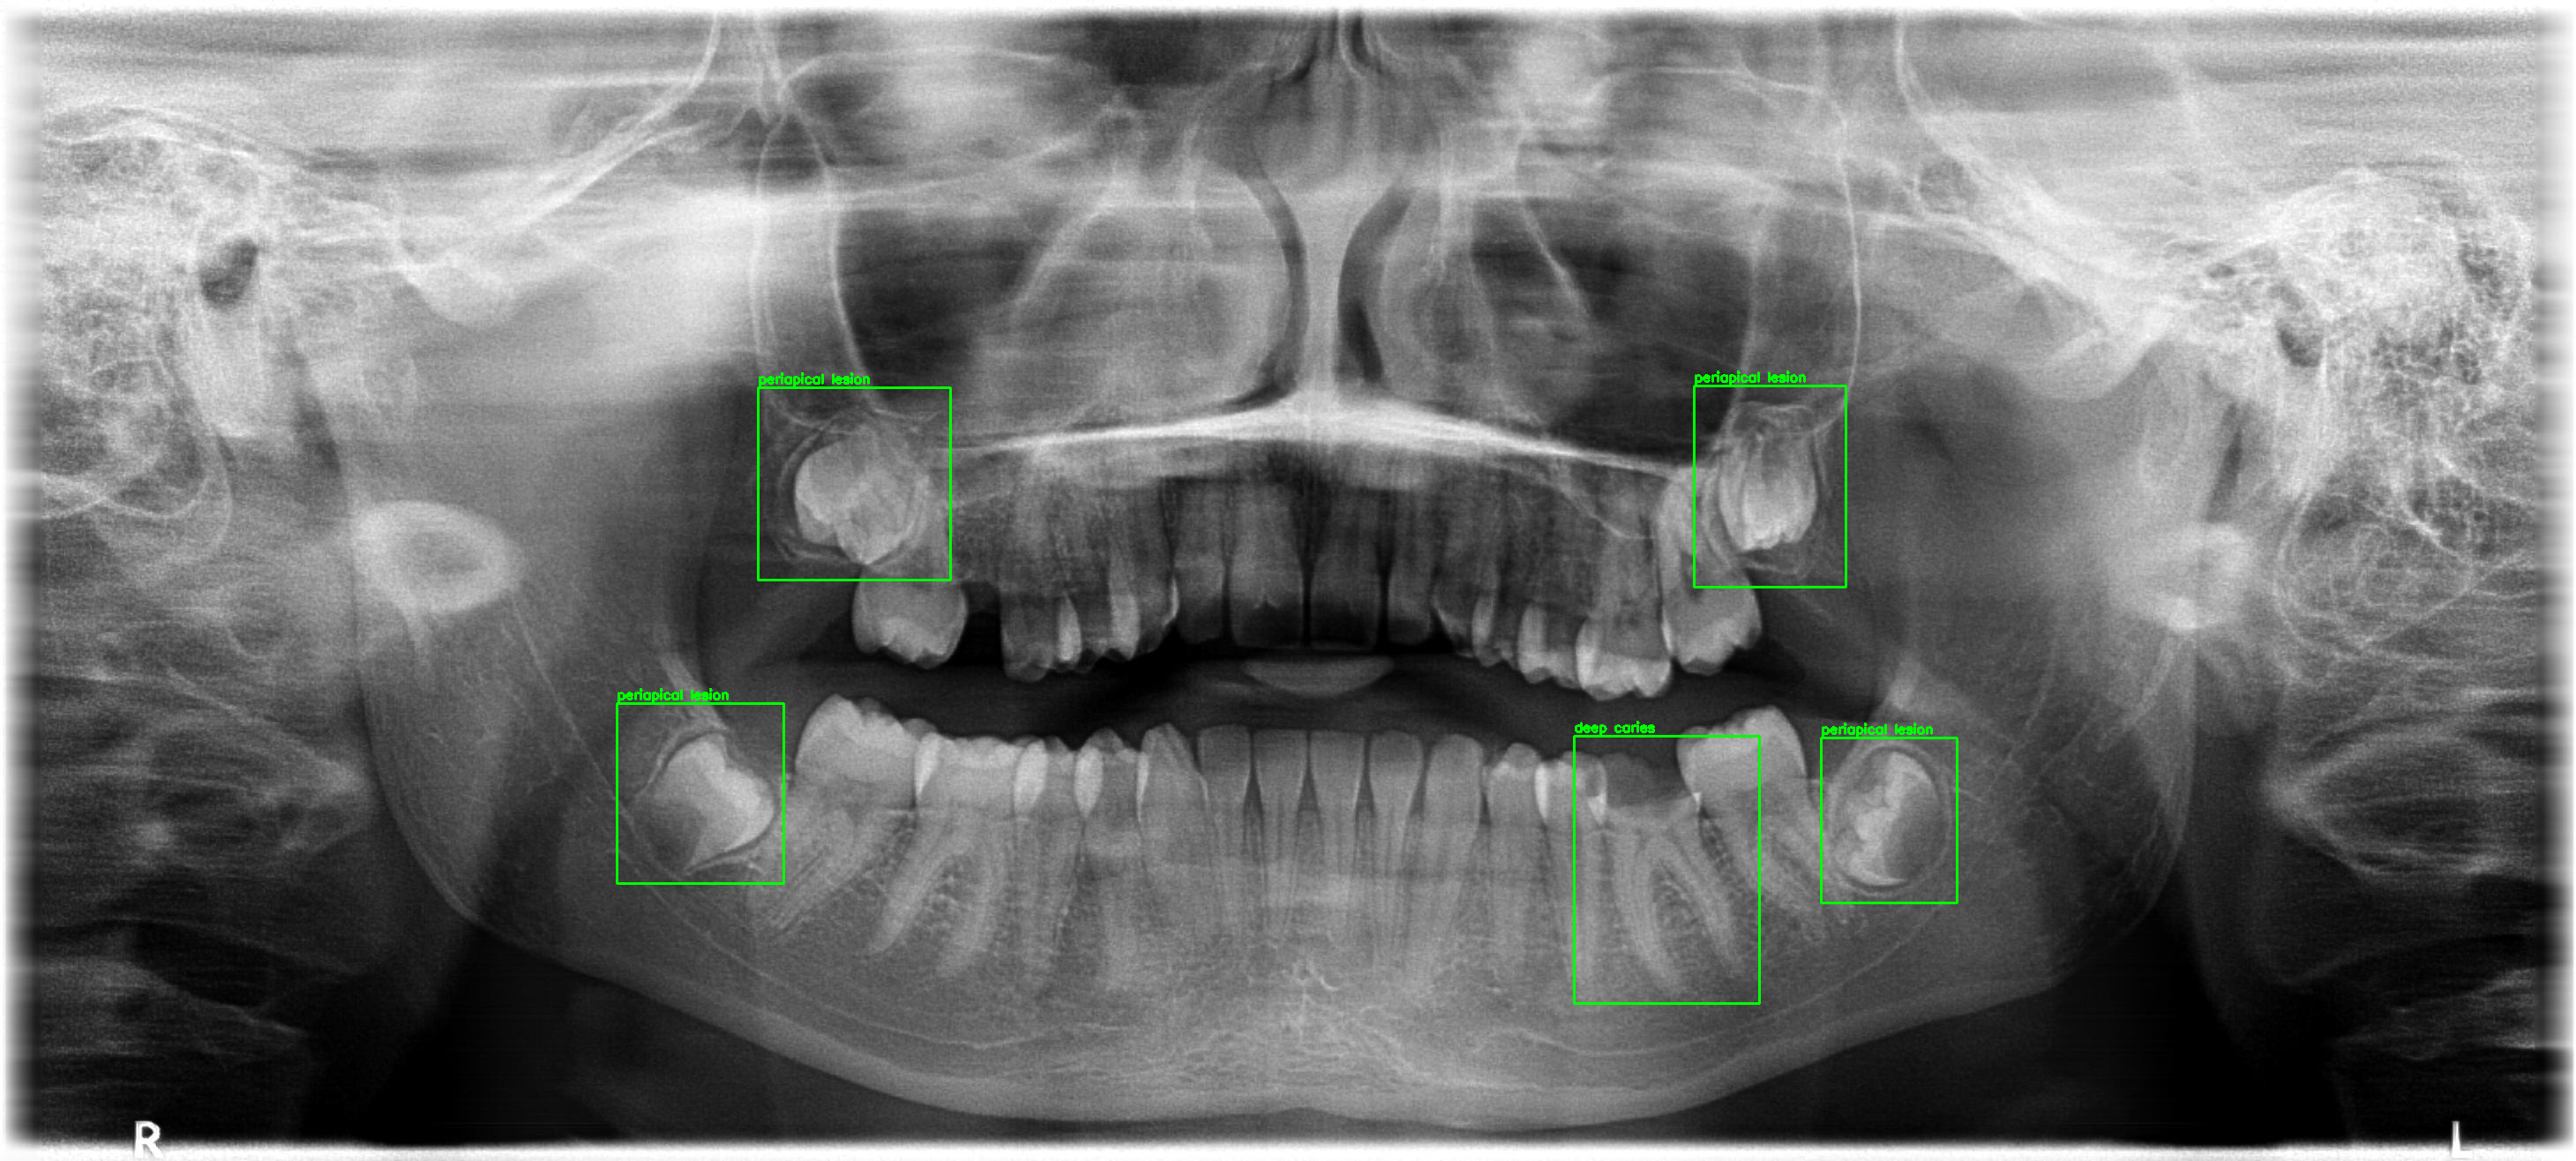

predicted image


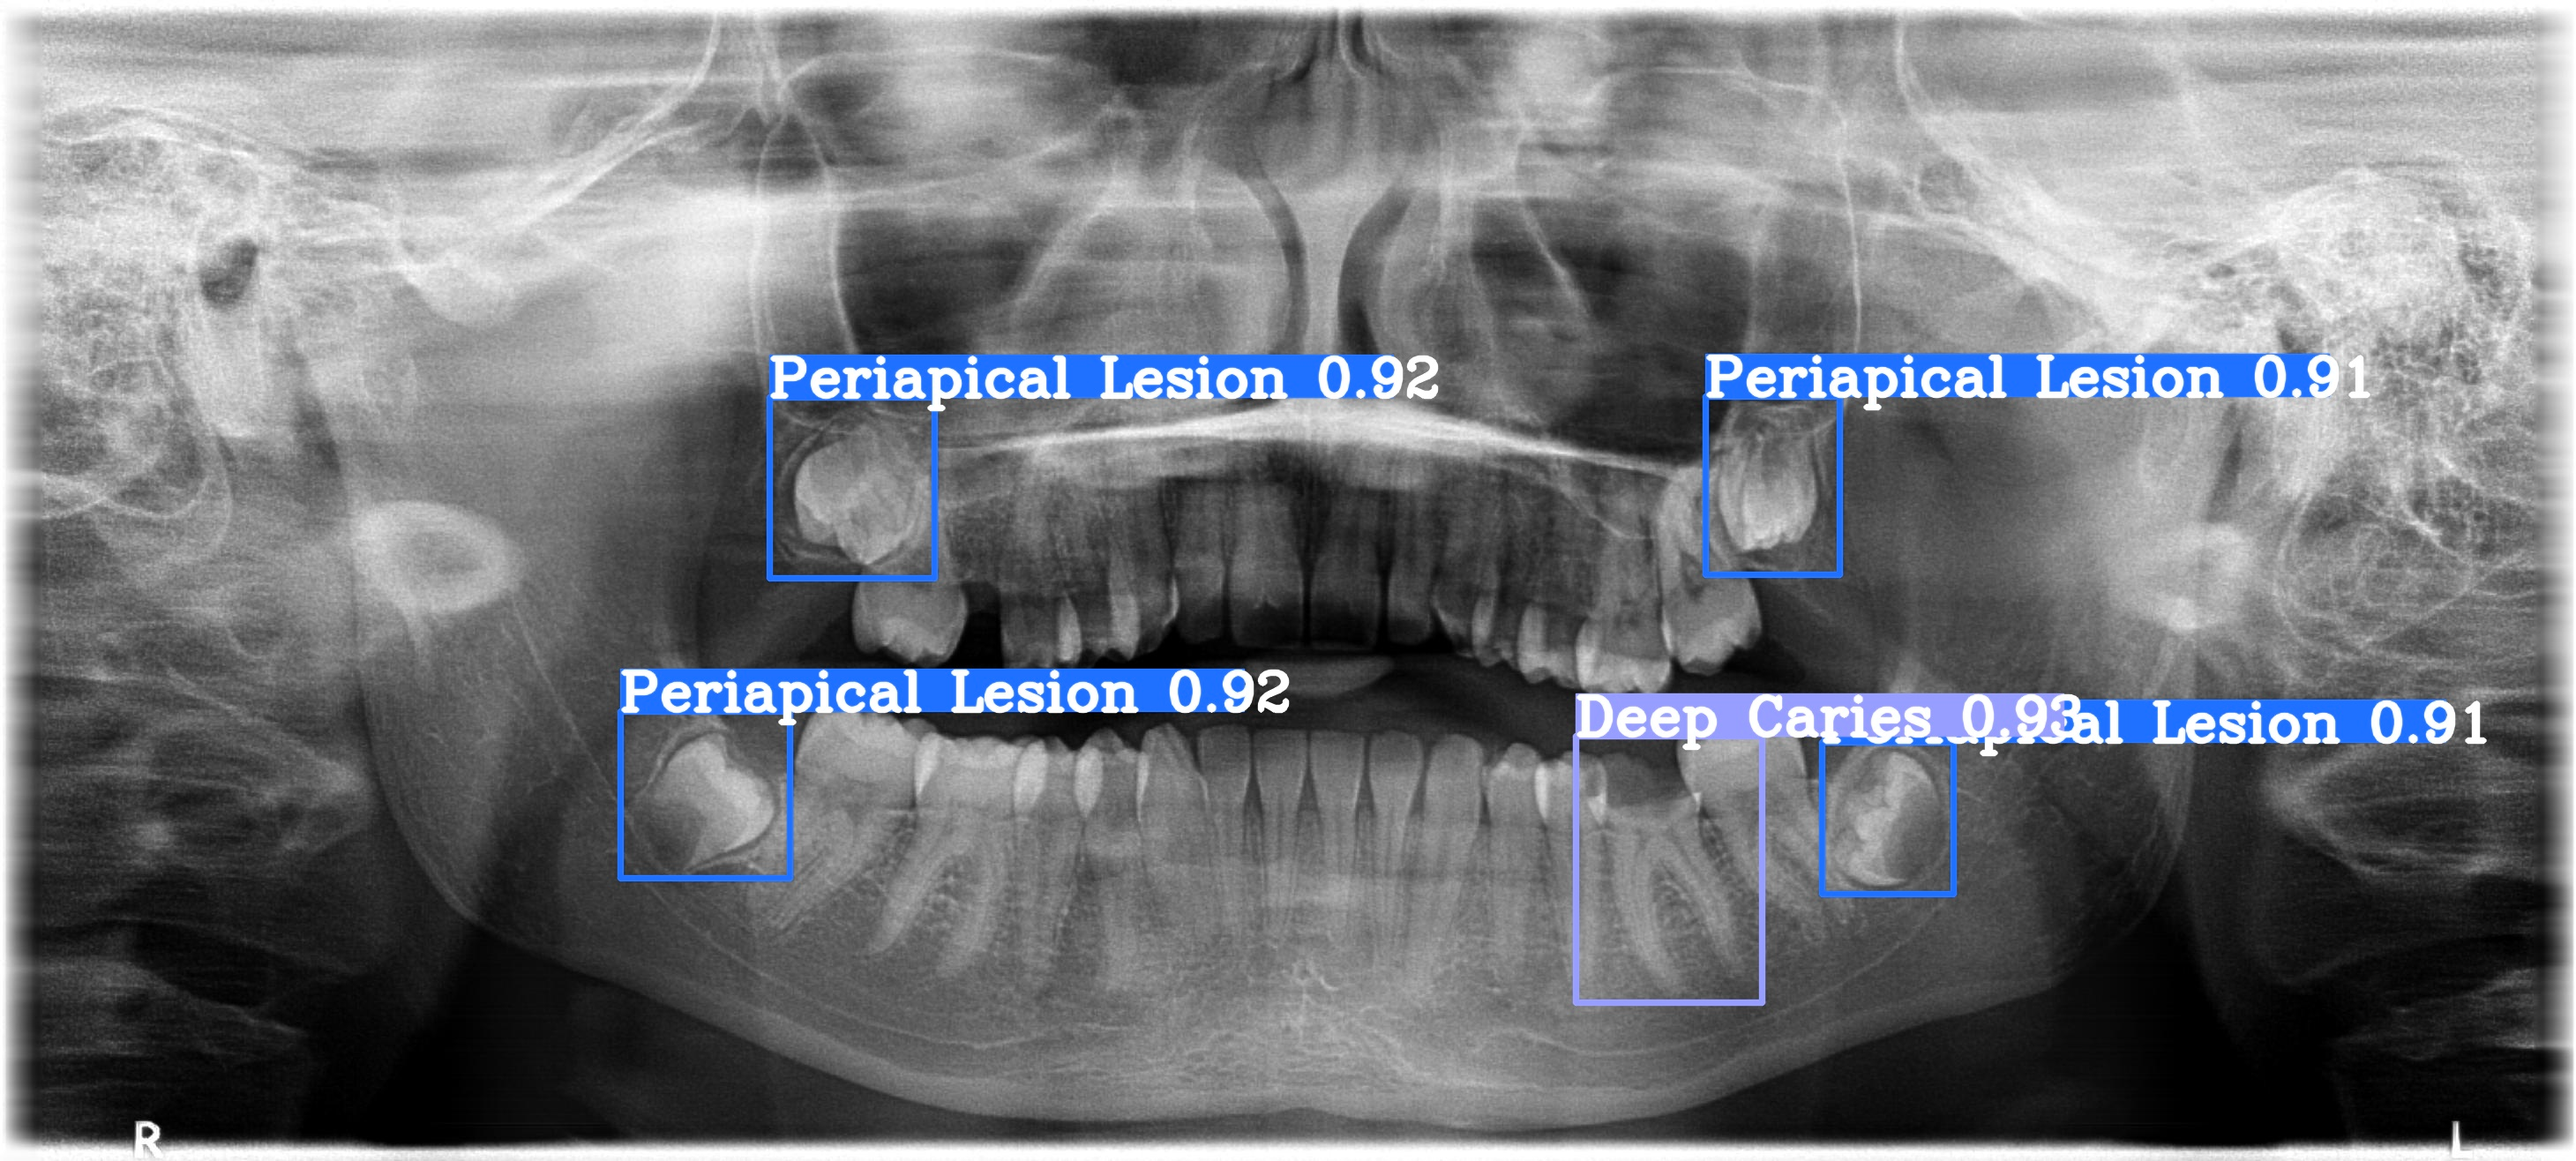

In [28]:

name = 'Image_7'
print("what the image should look like")
imagePath = IMAGE_DIR + '\\train\\'
labelsPath = LABEL_DIR + "\\train\\"
img = getDisplayImage(imagePath, labelsPath, name)
display(Image.fromarray(img))
# Save the image
target_dir = "runs\\inference\\self_attention\\correct_labels"
os.makedirs(target_dir, exist_ok=True)
cv2.imwrite(os.path.join(target_dir, name + ".jpg"), img)

# load the predicted image
img = cv2.imread('runs\\inference\\self_attention\\val\\' + name + ".jpg")
print("predicted image")
display(Image.fromarray(img))


# Run the server as a demonstration

In [33]:
!streamlit run server.py

^C
